# Распознавание еды

## Detectron2 baseline

В данном ноутбуке представлен baseline модели детекции еды с помощью фреймворка detectron2. Вы можете (и это даже лучше) использовать другие модели (например YOLO, mmdet), или написать полностью свою.

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [1]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

In [2]:
import tqdm

In [3]:
from matplotlib import pyplot as plt

In [4]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [5]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 2. Валидационный датасет

Для валидации наших моделей нам неплохо было создать из обучающих данных валидационный датасет. Для этого разделим наш датасет на две части - для обучения и для валидации. Для этого просто создадим два новых файлика с аннотациями, куда раздельно запишем исиходную информацию об аннотациях.

In [7]:
import json
#Подгрузим аннотации train
with open('data/train/annotations.json') as f:
    annotations = json.load(f)

In [8]:
#Пустой словарь для аннотаций валидации
annotations_val = {}
#Список категорий такой же как в train
annotations_val['categories'] = annotations['categories']

#Пустой словарь для аннотаций нового train
annotations_train = {}
#Список категорий такой же как в train
annotations_train['categories'] = annotations['categories']


#Положим в валидацию каждое 15 изображение из исходного train, а остальные - в новый train
annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%15==0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

#Положим в список аннотаций валидации только те аннотации, которые относятся к изображениям из валидации. 
#А в список аннотаций нового train - только те, которые относятся к нему
val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')

Готово! Аннотации для валидации и новой обучающей выборки готовы, теперь просто сохраним их в формате json, и положим в папке. Назовем аннотации annotations_new.json, чтобы новая набор аннотаций для train (без множества val) не перезаписал исходные аннотации.

In [9]:
if not os.path.exists('data/val'):
    os.makedirs('data/val')
if not os.path.exists('data/val/images'):
    os.makedirs('data/val/images')

Скопируем изображения, которые относятся к валидации, в папку val/images

In [10]:
for i in annotations_val['images']:
    shutil.copy('data/train/images/'+i['file_name'],'data/val/images/')

Запишем новые файлы с аннотациями для train и val.

In [11]:
with open('data/val/annotations_new.json', 'w') as outfile:
    json.dump(annotations_val, outfile)
    
    
with open('data/train/annotations_new.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

# 3. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [12]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("./data/{}/annotations_new.json".format(d),
    image_root= "./data/train/images",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [13]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И тестовую выборку в **dataset_dicts_val**

In [14]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

Посмотрим на размер получившихся выборок - эта операция в python осуществляется при помощи функции **len()**

In [15]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 10726
Размер тестовой выборки (Картинки): 767


Итак, у нас в распоряжении 10726 изображения для тренировки, и 767 - для проверки качества.

**Посмотрим на размеченные фотографии из валидации**

In [16]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

In [17]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

В целом, Вы можете посмотреть и другие архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Теперь задаем параметры самой модели и обучения модели

In [18]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы 
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая 
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 300
cfg.INPUT.MAX_SIZE_TRAIN = 300

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат. 
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5, 
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR), 
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = 'BGR' 

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 12, 
# но максимум может быть гораздо выше.
cfg.DATALOADER.NUM_WORKERS = 12

# Следующий параметр задает количество изображений в батче, на котором 
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 20

# Зададим также learning_rate
cfg.SOLVER.BASE_LR = 0.01

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (1000,)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 1000

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 41

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом 
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = './output'

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду. 
#%rm output/*

**4.2. Обучаем модель**

Процесс обучения модели запускают следующие три строчки кода. Возможно будут предупреждения, на которые можно не обращать внимания, это информация об обучении.

In [19]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/03 23:45:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (42, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (42,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (164, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (164,) in the model! You might want to double check if this is expected.


[02/03 23:45:36 d2.engine.train_loop]: Starting training from iteration 0
[02/03 23:46:03 d2.utils.events]:  eta: 0:19:33  iter: 19  total_loss: 3.5  loss_cls: 3.285  loss_box_reg: 0.1756  loss_rpn_cls: 0.03157  loss_rpn_loc: 0.007571  time: 1.2089  data_time: 0.1676  lr: 0.00019981  max_mem: 4101M
[02/03 23:46:27 d2.utils.events]:  eta: 0:19:09  iter: 39  total_loss: 0.6161  loss_cls: 0.3782  loss_box_reg: 0.1978  loss_rpn_cls: 0.03021  loss_rpn_loc: 0.007122  time: 1.2110  data_time: 0.0719  lr: 0.00039961  max_mem: 4119M
[02/03 23:46:52 d2.utils.events]:  eta: 0:18:56  iter: 59  total_loss: 0.5205  loss_cls: 0.2951  loss_box_reg: 0.199  loss_rpn_cls: 0.0197  loss_rpn_loc: 0.006512  time: 1.2227  data_time: 0.0742  lr: 0.00059941  max_mem: 4121M
[02/03 23:47:16 d2.utils.events]:  eta: 0:18:37  iter: 79  total_loss: 0.5058  loss_cls: 0.2818  loss_box_reg: 0.2036  loss_rpn_cls: 0.0225  loss_rpn_loc: 0.006825  time: 1.2170  data_time: 0.0622  lr: 0.00079921  max_mem: 4121M
[02/03 23:47:

Используем обученную модель для проверки качества на валидации.

In [20]:
cfg.MODEL.WEIGHTS = "output/model_0000999.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_val", )
#Изменение размера исходных изображений для тестового датасета
cfg.INPUT.MIN_SIZE_TEST= 300
cfg.INPUT.MAX_SIZE_TEST = 300
cfg.INPUT.FORMAT = 'BGR'

predictor = DefaultPredictor(cfg)

Сделаем предсказания для тестового датасета и сразу же нарисуем его.

Вы можете выбрать из выпадающего списка номер изображения, и посмотреть разметку на всем тестовом датасете.

In [21]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Можно непосредственно в коде изменить номер изображения, которое Вы хотите обработать.

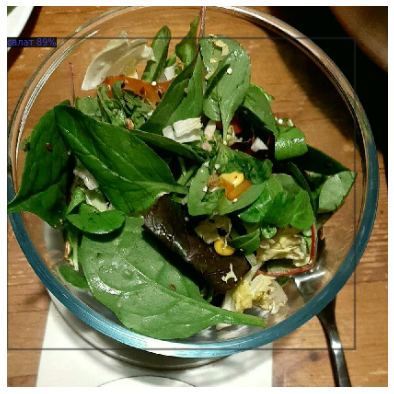

In [22]:
id_image_selected = 3
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

Посмотрим на качество предсказаний для всей валидационной выборки.

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
quality = inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [02/04 00:20:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[02/04 00:20:40 d2.evaluation.coco_evaluation]: 'my_dataset_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/04 00:20:40 d2.data.datasets.coco]: Converting annotations of dataset 'my_dataset_val' to COCO format ...)
WARNING [02/04 00:20:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 00:20:40 d2.data.datasets.coco]: Loaded 767 images in COCO format from ./transformed_data/to_admin/val/annotations_new.json
[02/04 00:20:40 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/04 00:20:40 d2.data.datasets.coco]: Conversion finished, #images: 767, #annotations: 1004
[02/04 00:20:40 d2.data.datasets.coco]: Caching COCO format annotations at './output/my_dataset_val_coco_format.json' ...
WA

In [24]:
quality

OrderedDict([('bbox',
              {'AP': 18.805098502463487,
               'AP50': 31.622695116868755,
               'AP75': 20.87454417819079,
               'APs': 0.0,
               'APm': 5.071507150715072,
               'APl': 18.98104018462797,
               'AP-картофель фри': 14.00990099009901,
               'AP-салями': 0.0,
               'AP-брокколи': 24.7040704070407,
               'AP-батат': 3.3663366336633667,
               'AP-мед': 0.0,
               'AP-рис': 16.904036557501904,
               'AP-миндаль': 10.396039603960396,
               'AP-хлеб': 40.57744151217732,
               'AP-цукини': 0.0,
               'AP-курица': 0.0,
               'AP-вода': 41.768806771873265,
               'AP-вино красное': 43.43608382577388,
               'AP-варенье': 4.884488448844884,
               'AP-сыр': 11.164347203951163,
               'AP-лосось': 0.0,
               'AP-помидор': 28.619619539593717,
               'AP-лимон': 20.198019801980198,
     

# Запись submission

Возьмем нашу обученную модель и запишем предсказания в файл predict.json

In [25]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import Boxes, BoxMode 


In [26]:
def instances_to_coco_json(instances, img_id):
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
    
        results.append(result)
    return results


In [27]:
def run(test_images_path,predictions_output_path):
    threshold = 0.5
    model_path = "./output/model_0000999.pth"
    cpu_device = torch.device("cpu")


    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 41
    cfg.INPUT.MIN_SIZE_TEST= 300
    cfg.INPUT.MAX_SIZE_TEST = 300
    cfg.INPUT.FORMAT = 'BGR'
    
    #cfg.MODEL.DEVICE = "cpu"
    predictor = DefaultPredictor(cfg)
    results = []
    del cfg
    for i in tqdm.tqdm(os.listdir(test_images_path)):
        img_path =test_images_path + "/" +str(i)
        im = cv2.imread(img_path)
        outputs = predictor(im)
        instances = outputs["instances"].to(cpu_device)
        fname = int(i.split('.')[0])
        result = instances_to_coco_json(instances,fname)
        if(len(result)!=0):
            for ele in result:
                results.append(ele)    

    fp = open(predictions_output_path, "w")
    fp.write(json.dumps(results))
    fp.close()



В функцию передаем два аргумента:
* путь к папке с изображениями, на которых хотим сделать предсказания. сейчас это путь к валдиационными изображениям. При загрузке вашего образа стоит использовать путь ./test/images. Папку test мы положим во время запуска контейнера.
* названия файла с предсказаниями. по время локального дебага можно использовать любое имя, для сабмита в систему стоит использовать название prediction.json

Этот же код вынесен в отдельные скрипты для удобства, они должны запускаться во время хапуска контейнера.

In [29]:
run('data/val/images','predict.json')

100%|██████████| 767/767 [00:56<00:00, 13.61it/s]


# Оценка качества.

Оценка качества на нашей стороне просходит по следующему скрипту.

In [32]:
from pycocotools.coco import COCO
from cocoeval import COCOeval #требуется файлик cocoeval.py
import json

In [34]:
ground_truth_annotations = COCO('data/val/annotations_new.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [35]:
submission_file = json.loads(open("predict.json").read())

In [36]:
results = ground_truth_annotations.loadRes(submission_file)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [37]:
cocoEval = COCOeval(ground_truth_annotations, results, 'bbox')

In [38]:

cocoEval.evaluate()
cocoEval.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.17s).


In [39]:
average_precision = cocoEval._summarize(ap=1, iouThr=0.5, areaRng="all", maxDets=100)
average_recall = cocoEval._summarize(ap=0, iouThr=0.5, areaRng="all", maxDets=100)
print("Average Precision : {} || Average Recall : {}".format(average_precision, average_recall))


 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.340
Average Precision : 0.3181520203035733 || Average Recall : 0.33957406721921
